In [8]:
#num 1
from base_functions import * 

<Figure size 640x480 with 0 Axes>

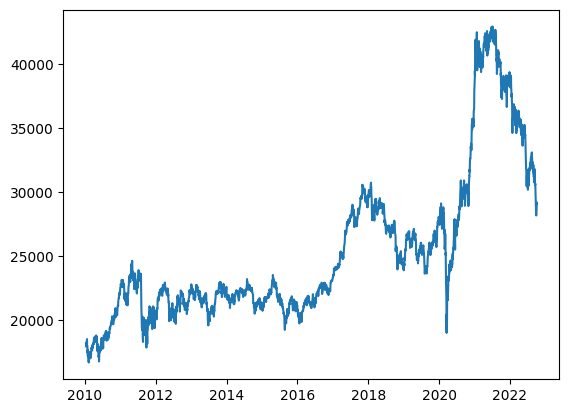

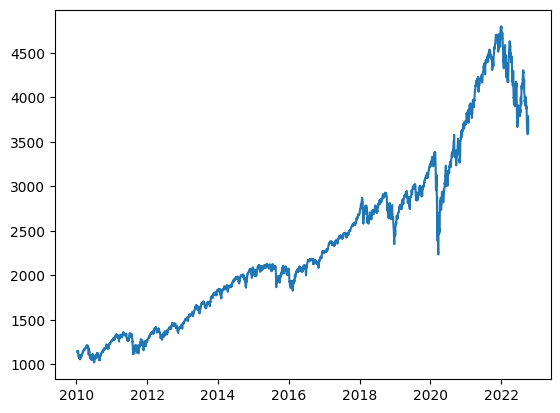

In [9]:
def getAllCloseData(tickers, start, end=None):
    closeData = []
    for ticker in tickers.values():
        closeData.append(getCloseData(ticker, start, end))

    closeData = pd.concat(closeData, axis=1)
    closeData.columns = [key for key in tickers.keys()]
    return closeData

tickers = {"kodex200": "069500", "s&p200": "^GSPC"}
start, end = "2010-01-10", "2022-10-10"
closeData = getAllCloseData(tickers, start, end)
closeData.dropna(inplace=True)

plt.figure()
plt.subplots()
plt.plot(closeData["kodex200"])
plt.subplots()
plt.plot(closeData["s&p200"])




In [10]:
def getMomentumScore(closeData, n=12):   
    priceOnRebal = closeData.loc[getRebalancingDate(closeData)]
    momentum = priceOnRebal - priceOnRebal.shift(12)
    momentum.dropna(inplace=True)

    return momentum

momentum = getMomentumScore(closeData)
print(momentum)

            kodex200      s&p200
Date                            
2011-01-31    5488.0  212.250000
2011-02-28    4292.0  222.729980
2011-03-31    5023.0  156.399902
2011-04-29    5473.0  176.920044
2011-05-31    6295.0  255.789917
...              ...         ...
2022-06-30  -12108.0 -512.120117
2022-07-29   -9213.0 -264.969727
2022-08-31   -8880.0 -567.680176
2022-09-30  -11073.0 -721.919922
2022-10-07   -8920.0 -965.719971

[142 rows x 2 columns]


In [11]:
def getWeightByMomentum(momentum, closeData):
    weight = {}
    weight[momentum.columns[0]] = np.where(momentum[momentum.columns[0]] > momentum[momentum.columns[1]], 1.0, 0.0)
    weight[momentum.columns[1]] = np.where(momentum[momentum.columns[1]] >= momentum[momentum.columns[0]], 1.0, 0.0)
    
    return pd.DataFrame(weight, index=momentum.index)
    
weight = getWeightByMomentum(momentum, None)
print(weight)

            kodex200  s&p200
Date                        
2011-01-31       1.0     0.0
2011-02-28       1.0     0.0
2011-03-31       1.0     0.0
2011-04-29       1.0     0.0
2011-05-31       1.0     0.0
...              ...     ...
2022-06-30       0.0     1.0
2022-07-29       0.0     1.0
2022-08-31       0.0     1.0
2022-09-30       0.0     1.0
2022-10-07       0.0     1.0

[142 rows x 2 columns]


In [12]:

def getRebalancingPortfolioResult(closeDataSet, period = "month", weightDf=None):

    # 자산별 비중. 기본값: 동일비중
    if weightDf is None:
        rebalancingDate = getRebalancingDate(closeDataSet, period) # 리밸런싱 날짜
        weightDf = pd.DataFrame([[1/len(closeDataSet.columns)] * len(closeDataSet.columns)]
                                * len(rebalancingDate),index=rebalancingDate,columns=closeDataSet.columns)
        
    # 자산별 비중이 있는 경우
    else:
        closeDataSet = closeDataSet.loc[weightDf.index[0]:]
        rebalancingDate = getRebalancingDate(closeDataSet, period) # 리밸런싱 날짜

    portfolio = pd.DataFrame() # 빈 데이터 프레임 생성
    totalAsset = 1 # 총 자산, 초기값 1
    start = rebalancingDate[0] # 리밸런싱 날짜, 초기값 첫 투자일

    for end in rebalancingDate[1:]:
        weight = weightDf.loc[end] # 당월 리밸런싱 비율
        priceData = closeDataSet.loc[start:end] # 당월 가격 데이터
        cumReturn = getCumulativeReturn(priceData) # 당월 누적 수익률
        weightedCumReturn = weight * cumReturn # 당월 리밸런싱 비율이 반영된 누적 수익
        netCumReturn = totalAsset * weightedCumReturn # 전월 투자 결과 반영
        start = end # start 갱신
        totalAsset = netCumReturn.iloc[-1].sum() # 총 자산 갱신
        portfolio = pd.concat([portfolio, netCumReturn]) # 매월 데이터 추가

    portfolio = portfolio.loc[~portfolio.index.duplicated(keep='last')] # 중복 데이터
    portfolioCumulativeReturn = portfolio.sum(axis=1) # 포트폴리오 누적 수익률
    portfolioDayReturn = (portfolioCumulativeReturn / portfolioCumulativeReturn.shift(1)).fillna(1)

    return portfolioDayReturn, portfolioCumulativeReturn

    

dayRet, cumRet = getRebalancingPortfolio(closeData, weightDf=weight)
print(dayRet)

Date
2011-01-31         NaN
2011-02-01    1.001982
2011-02-07    1.003428
2011-02-08    0.992248
2011-02-09    0.988921
                ...   
2022-09-30    0.984933
2022-10-04    1.057259
2022-10-05    0.997982
2022-10-06    0.989755
2022-10-07    0.971996
Length: 2790, dtype: float64


return: 1.8323027679455859 
 cagr: 1.056220492285517 
 mdd: 35.34490662505522


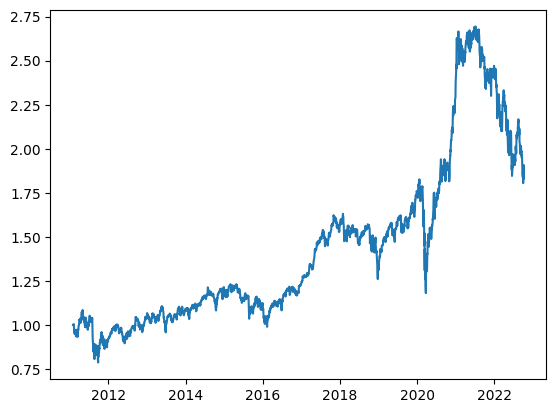

In [13]:
def getEval(cumRet):
    cagr = cumRet.iloc[-1] ** (252/len(cumRet))

    dd = (cumRet.cummax() - cumRet) / cumRet.cummax() * 100
    mdd = dd.max()
       
    print(f"return: {cumRet.iloc[-1]} \n cagr: {cagr} \n mdd: {mdd}")
    
    return cagr, dd, mdd

cagr, dd, mdd = getEval(cumRet)
plt.figure()
plt.plot(cumRet)